In [1]:
# CASE DE VENDAS ATUALIZADO COM MAIS MODELOS E BACKTEST

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoETS, AutoARIMA, Naive, SeasonalNaive

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
# 1. Carregar dados
df = pd.read_csv(r"resumo_vendas_regiao 1.csv")

df = df.rename(columns={
 
    "data": "ds",
    "vendas": "y"
})


df['ds'] = pd.to_datetime(df['ds'])

# Agrupar por mês
df_grouped = df.groupby(df['ds'].dt.to_period('M'))['y'].sum().reset_index()
df_grouped['ds'] = df_grouped['ds'].dt.to_timestamp()

# Ajustar colunas para StatsForecast
df_grouped['unique_id'] = 'serie1'
df_grouped = df_grouped[['unique_id', 'ds', 'y']]

print(df_grouped.head())


  unique_id         ds            y
0    serie1 2021-01-01   3632707.42
1    serie1 2021-02-01  12812183.31
2    serie1 2021-03-01  21306031.44
3    serie1 2021-04-01   2329599.24
4    serie1 2021-05-01   9424709.03


In [4]:
# 2. Definir modelos
sf = StatsForecast(
    models=[
        AutoETS(season_length=12),
        AutoARIMA(season_length=12),
        Naive(),
        SeasonalNaive(season_length=12)
    ],
    freq='ME',
    n_jobs=-1
)


In [20]:
# 3. Cross-validation (backtest)
cv_results = sf.cross_validation(
    df=df_grouped,
    h=12,
    step_size=12,
    n_windows=3
)

print(cv_results.head())


                  ds     cutoff           y     AutoETS   AutoARIMA  \
unique_id                                                             
serie1    2022-09-01 2022-08-01   6855019.5  10410530.0  10113390.0   
serie1    2022-10-01 2022-08-01  15056373.0  10410530.0  10113388.0   
serie1    2022-11-01 2022-08-01   9206098.0  10410530.0  10113386.0   
serie1    2022-12-01 2022-08-01  12771209.0  10410530.0  10113384.0   
serie1    2023-01-01 2022-08-01  19653944.0  10410530.0  10113382.0   

                Naive  SeasonalNaive       Theta  DynamicOptimizedTheta  
unique_id                                                                
serie1     11548621.0      6269797.0  10769634.0              9672385.0  
serie1     11548621.0      5120251.5  10830575.0              9672385.0  
serie1     11548621.0     19376806.0  10891515.0              9672385.0  
serie1     11548621.0     10202009.0  10952456.0              9672385.0  
serie1     11548621.0      5096952.5  11013396.0          

C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [21]:
# 4. Calcular métricas para cada modelo
def calc_metrics(df, model):
    df_eval = df.dropna(subset=['y', model])
    y_true = df_eval['y'].values
    y_pred = df_eval[model].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

metrics = {}
for model in ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive']:
    metrics[model] = calc_metrics(cv_results, model)

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                    RMSE        MAE       MAPE        R2
AutoETS        7913275.0  4843473.5  49.928596 -0.029795
AutoARIMA      8433191.0  5064096.0  48.082291 -0.169559
Naive          8574642.0  5409841.5  55.788254 -0.209122
SeasonalNaive  9415882.0  5947142.5  57.639511 -0.458009


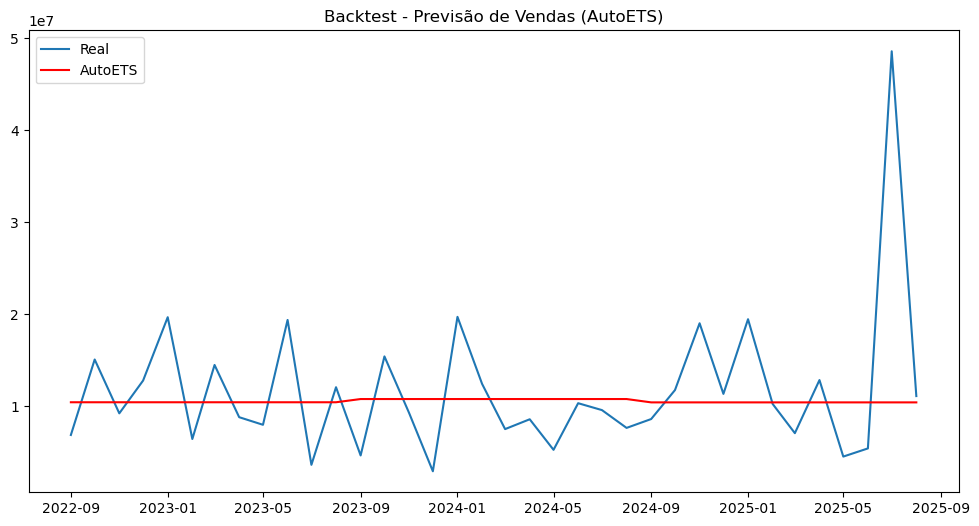

In [22]:
# 5. Plotar resultados do backtest (um exemplo com AutoETS)
df_eval = cv_results.dropna(subset=['y', 'AutoETS'])

plt.figure(figsize=(12,6))
plt.plot(df_eval['ds'], df_eval['y'], label='Real')
plt.plot(df_eval['ds'], df_eval['AutoETS'], label='AutoETS', color='red')
plt.legend()
plt.title("Backtest - Previsão de Vendas (AutoETS)")
plt.show()


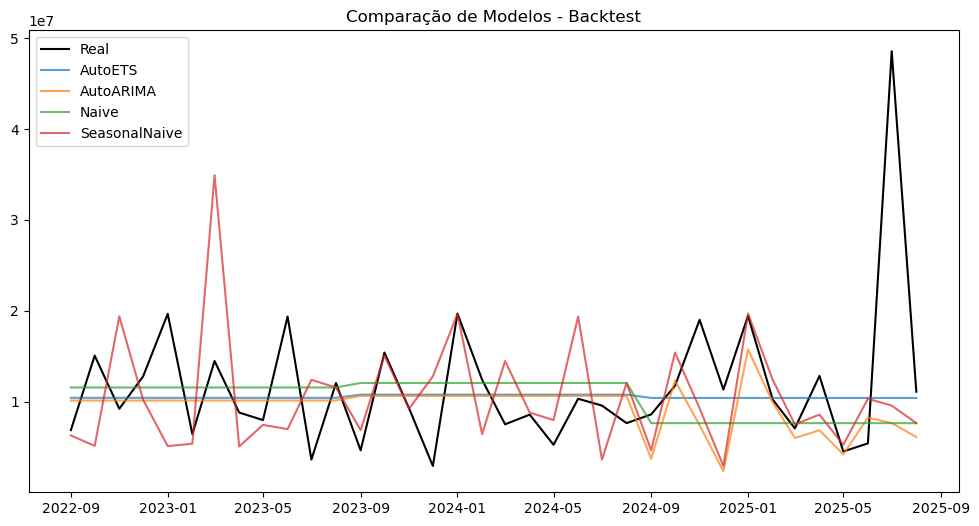

In [23]:
# 6. Plot comparativo de modelos (opcional)
plt.figure(figsize=(12,6))
plt.plot(cv_results['ds'], cv_results['y'], label='Real', color='black')

for model in ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive']:
    plt.plot(cv_results['ds'], cv_results[model], label=model, alpha=0.7)

plt.legend()
plt.title("Comparação de Modelos - Backtest")
plt.show()


In [24]:
from statsforecast.models import Theta, DynamicOptimizedTheta


In [25]:
sf = StatsForecast(
    models=[
        AutoETS(season_length=12),
        AutoARIMA(season_length=12),
        Naive(),
        SeasonalNaive(season_length=12),
        Theta(),
        DynamicOptimizedTheta(season_length=12)
    ],
    freq='ME',
    n_jobs=-1
)


In [11]:
cv_results = sf.cross_validation(
    df=df_grouped,
    h=12,
    step_size=12,
    n_windows=3
)

print(cv_results.head())


                  ds     cutoff           y     AutoETS   AutoARIMA  \
unique_id                                                             
serie1    2022-09-01 2022-08-01   6855019.5  10410530.0  10113390.0   
serie1    2022-10-01 2022-08-01  15056373.0  10410530.0  10113388.0   
serie1    2022-11-01 2022-08-01   9206098.0  10410530.0  10113386.0   
serie1    2022-12-01 2022-08-01  12771209.0  10410530.0  10113384.0   
serie1    2023-01-01 2022-08-01  19653944.0  10410530.0  10113382.0   

                Naive  SeasonalNaive       Theta  DynamicOptimizedTheta  
unique_id                                                                
serie1     11548621.0      6269797.0  10769634.0              9672385.0  
serie1     11548621.0      5120251.5  10830575.0              9672385.0  
serie1     11548621.0     19376806.0  10891515.0              9672385.0  
serie1     11548621.0     10202009.0  10952456.0              9672385.0  
serie1     11548621.0      5096952.5  11013396.0          

C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [12]:
def calc_metrics(df, model):
    df_eval = df.dropna(subset=['y', model])
    y_true = df_eval['y'].values
    y_pred = df_eval[model].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

models_to_eval = ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive', 'Theta', 'DynamicOptimizedTheta']
metrics = {m: calc_metrics(cv_results, m) for m in models_to_eval}

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                            RMSE        MAE       MAPE        R2
AutoETS                7913275.0  4843473.5  49.928596 -0.029795
AutoARIMA              8433191.0  5064096.0  48.082291 -0.169559
Naive                  8574642.0  5409841.5  55.788254 -0.209122
SeasonalNaive          9415882.0  5947142.5  57.639511 -0.458009
Theta                  8089175.5  5044384.5  53.058903 -0.076085
DynamicOptimizedTheta  8081776.0  4918096.0  48.570850 -0.074117


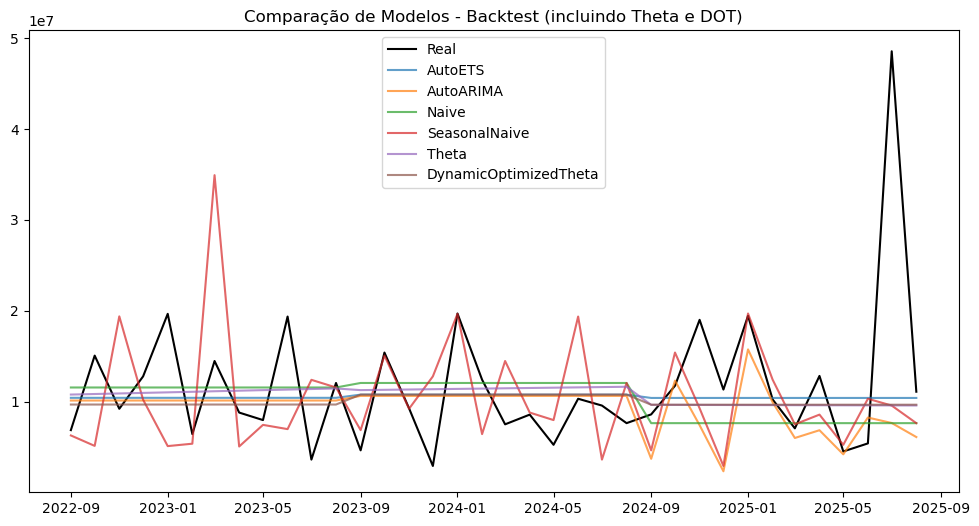

In [13]:
plt.figure(figsize=(12,6))
plt.plot(cv_results['ds'], cv_results['y'], label='Real', color='black')

for model in models_to_eval:
    plt.plot(cv_results['ds'], cv_results[model], label=model, alpha=0.7)

plt.legend()
plt.title("Comparação de Modelos - Backtest (incluindo Theta e DOT)")
plt.show()


In [14]:
def calc_metrics(df, model):
    df_eval = df.dropna(subset=['y', model])
    y_true = df_eval['y'].values
    y_pred = df_eval[model].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

models_to_eval = ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive', 'Theta', 'DynamicOptimizedTheta']
metrics = {m: calc_metrics(cv_results, m) for m in models_to_eval}

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                            RMSE        MAE       MAPE        R2
AutoETS                7913275.0  4843473.5  49.928596 -0.029795
AutoARIMA              8433191.0  5064096.0  48.082291 -0.169559
Naive                  8574642.0  5409841.5  55.788254 -0.209122
SeasonalNaive          9415882.0  5947142.5  57.639511 -0.458009
Theta                  8089175.5  5044384.5  53.058903 -0.076085
DynamicOptimizedTheta  8081776.0  4918096.0  48.570850 -0.074117


In [15]:
best_model = metrics_df['RMSE'].idxmin()
print(f"📌 Melhor modelo pelo RMSE: {best_model}")


📌 Melhor modelo pelo RMSE: AutoETS


In [16]:
# refazer StatsForecast só com o melhor modelo
model_map = {
    'AutoETS': AutoETS(season_length=12),
    'AutoARIMA': AutoARIMA(season_length=12),
    'Naive': Naive(),
    'SeasonalNaive': SeasonalNaive(season_length=12),
    'Theta': Theta(),
    'DynamicOptimizedTheta': DynamicOptimizedTheta(season_length=12)
}

sf_best = StatsForecast(
    models=[model_map[best_model]],
    freq='ME',
    n_jobs=-1
)

# fit no dataset completo
sf_best.fit(df_grouped)

# previsão para os próximos 12 meses
forecast_final = sf_best.predict(h=12)

print(forecast_final)


                  ds     AutoETS
unique_id                       
serie1    2025-08-31   5921025.5
serie1    2025-09-30  11045042.0
serie1    2025-10-31  13418504.0
serie1    2025-11-30   9136039.0
serie1    2025-12-31  14394217.0
serie1    2026-01-31   8784345.0
serie1    2026-02-28  19045126.0
serie1    2026-03-31   7609997.5
serie1    2026-04-30   6240851.0
serie1    2026-05-31  10325370.0
serie1    2026-06-30  25572960.0
serie1    2026-07-31  10319012.0


C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


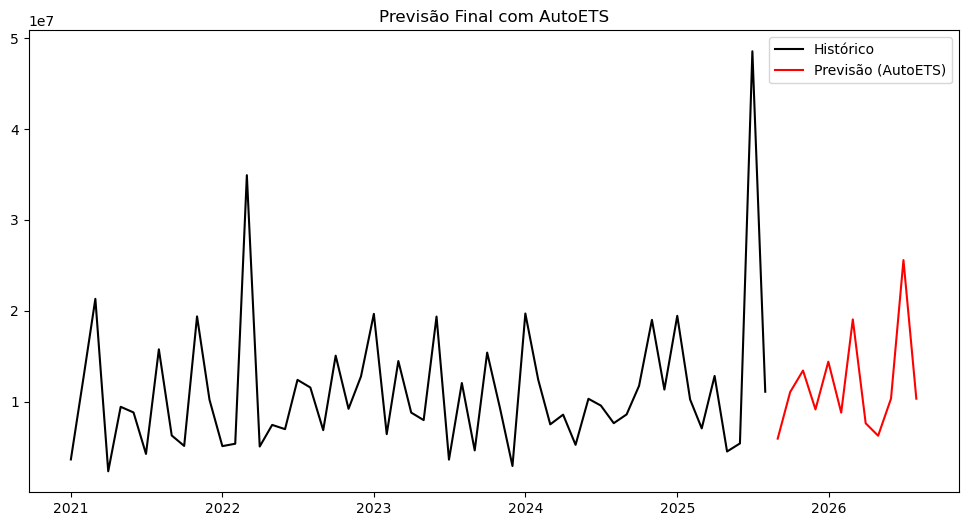

In [17]:
plt.figure(figsize=(12,6))
plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico", color="black")
plt.plot(forecast_final['ds'], forecast_final[best_model], label=f"Previsão ({best_model})", color="red")
plt.legend()
plt.title(f"Previsão Final com {best_model}")
plt.show()


C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


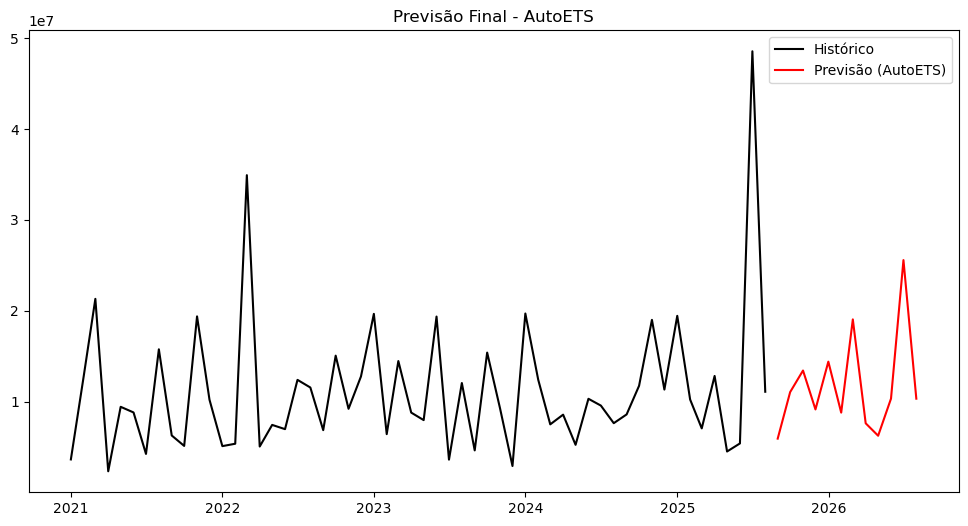

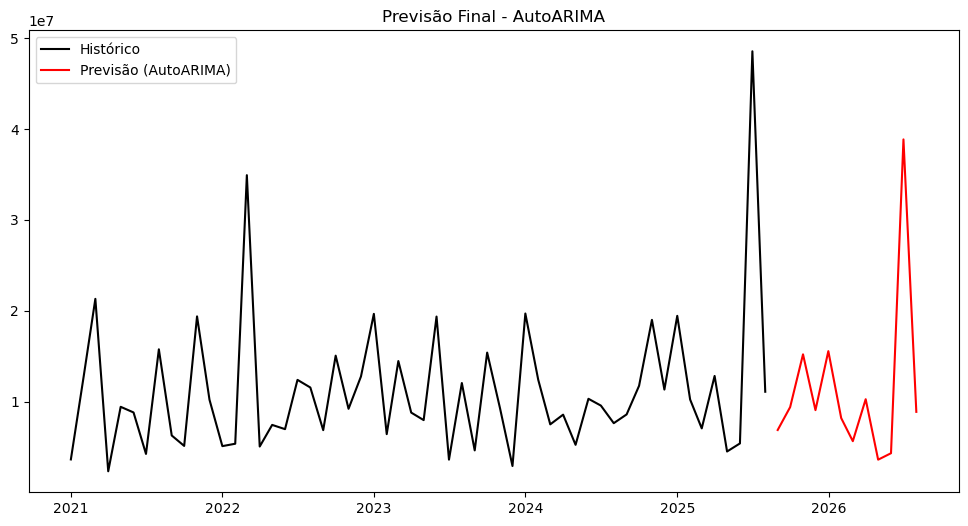

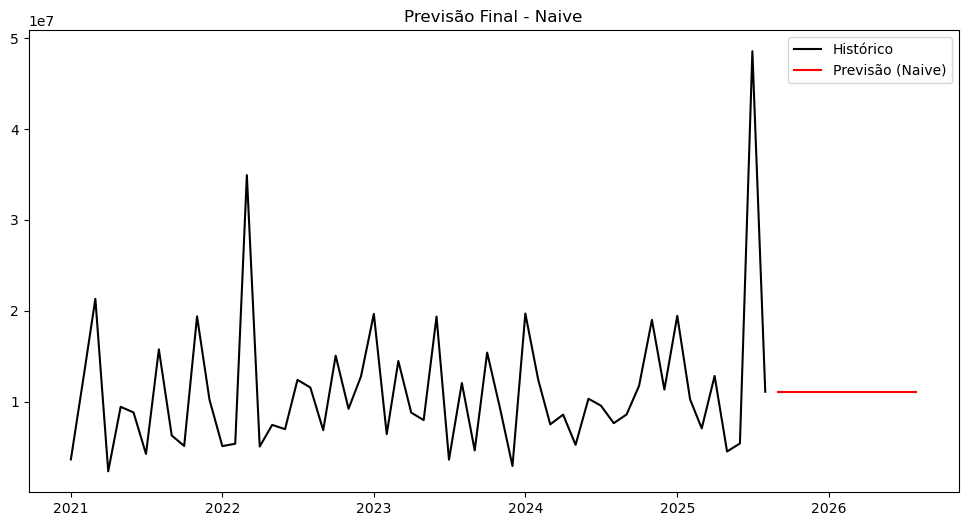

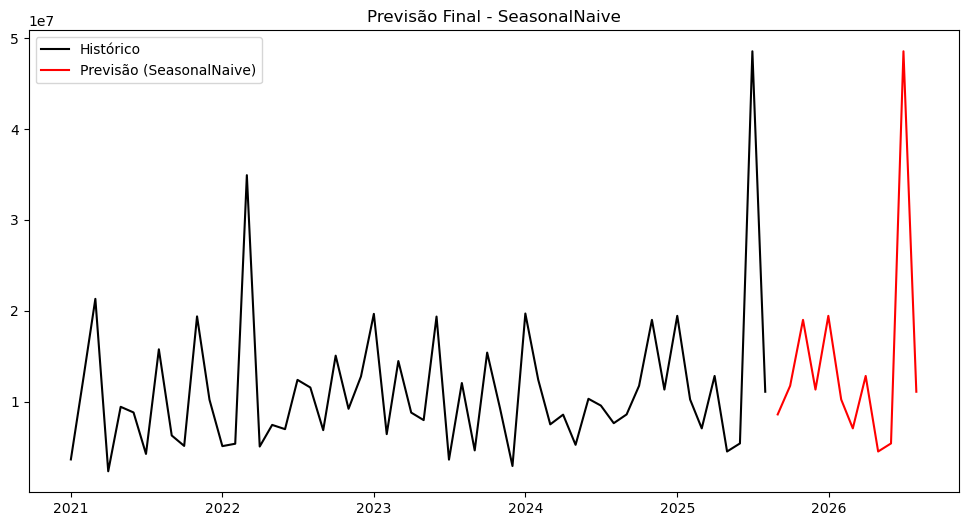

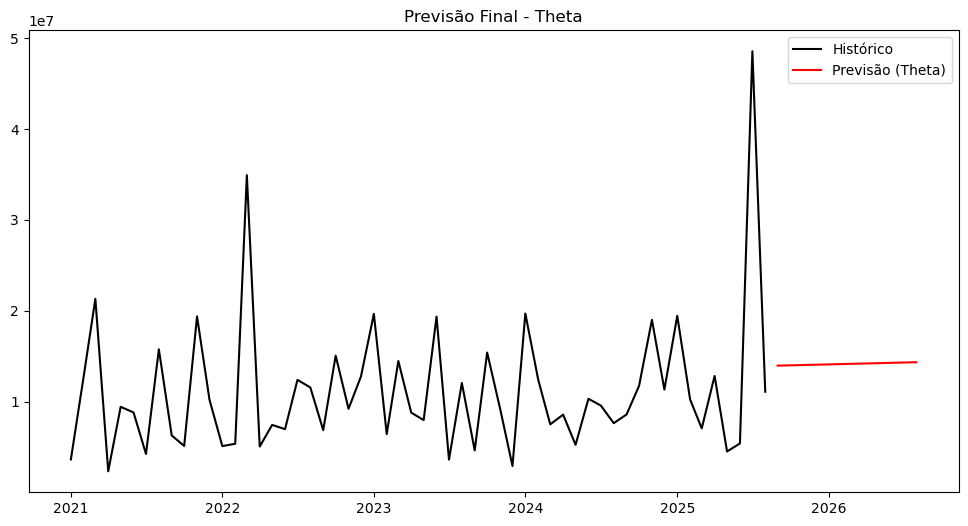

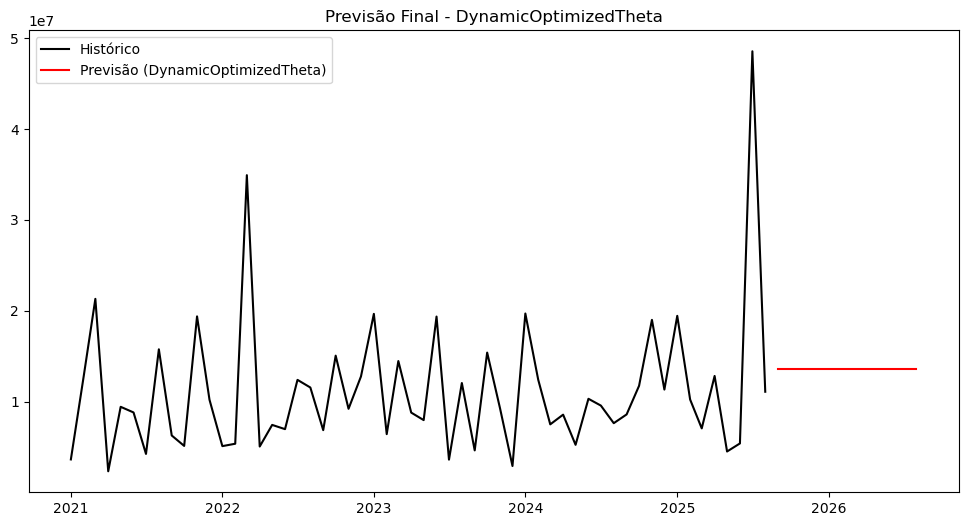

In [18]:
# Treinar e prever com todos os modelos
model_map = {
    'AutoETS': AutoETS(season_length=12),
    'AutoARIMA': AutoARIMA(season_length=12),
    'Naive': Naive(),
    'SeasonalNaive': SeasonalNaive(season_length=12),
    'Theta': Theta(),
    'DynamicOptimizedTheta': DynamicOptimizedTheta(season_length=12)
}

# rodar todos os modelos juntos
sf_all = StatsForecast(
    models=list(model_map.values()),
    freq='ME',
    n_jobs=-1
)
sf_all.fit(df_grouped)
forecast_all = sf_all.predict(h=12)

# gerar gráfico para cada modelo
for model in model_map.keys():
    plt.figure(figsize=(12,6))
    plt.plot(df_grouped['ds'], df_grouped['y'], label="Histórico", color="black")
    plt.plot(forecast_all['ds'], forecast_all[model], label=f"Previsão ({model})", color="red")
    plt.legend()
    plt.title(f"Previsão Final - {model}")
    plt.show()



In [19]:
# Treinar e prever com TODOS os modelos de uma vez
model_map = {
    'AutoETS': AutoETS(season_length=12),
    'AutoARIMA': AutoARIMA(season_length=12),
    'Naive': Naive(),
    'SeasonalNaive': SeasonalNaive(season_length=12),
    'Theta': Theta(),
    'DynamicOptimizedTheta': DynamicOptimizedTheta(season_length=12)
}

sf_all = StatsForecast(
    models=list(model_map.values()),
    freq='ME',
    n_jobs=-1
)

# fit no dataset completo
sf_all.fit(df_grouped)

# previsão para os próximos 12 meses
forecast_all = sf_all.predict(h=12)

# Mostra a tabela de previsões (cada coluna é um modelo)
print(forecast_all.head(20))


                  ds     AutoETS   AutoARIMA       Naive  SeasonalNaive  \
unique_id                                                                 
serie1    2025-08-31   5921025.5   6871632.5  11082438.0      8586799.0   
serie1    2025-09-30  11045042.0   9392773.0  11082438.0     11737219.0   
serie1    2025-10-31  13418504.0  15200856.0  11082438.0     18995004.0   
serie1    2025-11-30   9136039.0   9059005.0  11082438.0     11320141.0   
serie1    2025-12-31  14394217.0  15553179.0  11082438.0     19435268.0   
serie1    2026-01-31   8784345.0   8186082.0  11082438.0     10229336.0   
serie1    2026-02-28  19045126.0   5642671.0  11082438.0      7051087.0   
serie1    2026-03-31   7609997.5  10260999.0  11082438.0     12822155.0   
serie1    2026-04-30   6240851.0   3606816.5  11082438.0      4507081.5   
serie1    2026-05-31  10325370.0   4316549.0  11082438.0      5393964.0   
serie1    2026-06-30  25572960.0  38855752.0  11082438.0     48554188.0   
serie1    2026-07-31  103

C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Copiar série
df_ml = df_grouped.copy()

# Features de tempo
df_ml['year'] = df_ml['ds'].dt.year
df_ml['month'] = df_ml['ds'].dt.month

# Criar lags (valores anteriores)
df_ml['lag1'] = df_ml['y'].shift(1)
df_ml['lag2'] = df_ml['y'].shift(2)
df_ml['lag3'] = df_ml['y'].shift(3)

# Remover linhas com NaN (por causa dos lags)
df_ml = df_ml.dropna()

print(df_ml.head())


  unique_id         ds            y      y_log  y_scaled  year  month  \
3    serie1 2021-04-01   2329599.24  14.661207  0.000000  2021      4   
4    serie1 2021-05-01   9424709.03  16.058846  0.153492  2021      5   
5    serie1 2021-06-01   8803445.34  15.990654  0.140052  2021      6   
6    serie1 2021-07-01   4238210.82  15.259652  0.041290  2021      7   
7    serie1 2021-08-01  15752363.75  16.572501  0.290381  2021      8   

          lag1         lag2         lag3  
3  21306031.44  12812183.31   3632707.42  
4   2329599.24  21306031.44  12812183.31  
5   9424709.03   2329599.24  21306031.44  
6   8803445.34   9424709.03   2329599.24  
7   4238210.82   8803445.34   9424709.03  


In [30]:

X = df_ml[['year', 'month', 'lag1', 'lag2', 'lag3']]
y = df_ml['y']

# Separar treino e teste (últimos 12 meses como teste)
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

# Treinar modelo
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Prever
y_pred = rf.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")


RMSE: 9467588.81
MAE: 6545513.77
MAPE: 48.49%
R²: 0.30


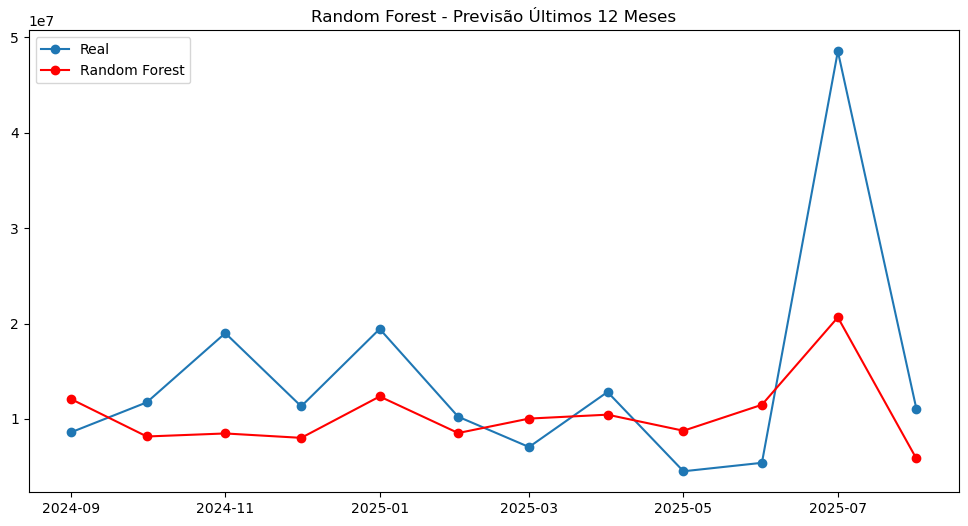

In [31]:

plt.figure(figsize=(12,6))
plt.plot(df_ml['ds'][-12:], y_test, label="Real", marker="o")
plt.plot(df_ml['ds'][-12:], y_pred, label="Random Forest", marker="o", color="red")
plt.legend()
plt.title("Random Forest - Previsão Últimos 12 Meses")
plt.show()


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Copiar a série
df_ml = df_grouped.copy()

# Features de tempo
df_ml['year'] = df_ml['ds'].dt.year
df_ml['month'] = df_ml['ds'].dt.month

# Criar lags
df_ml['lag1'] = df_ml['y'].shift(1)
df_ml['lag2'] = df_ml['y'].shift(2)
df_ml['lag3'] = df_ml['y'].shift(3)

# Remover NaNs
df_ml = df_ml.dropna()

# Definir X e y
X = df_ml[['year', 'month', 'lag1', 'lag2', 'lag3']]
y = df_ml['y']

# Últimos 12 meses como teste
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]



In [34]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost -> RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, MAPE: {mape_xgb:.2f}%, R²: {r2_xgb:.2f}")


XGBoost -> RMSE: 11213715.98, MAE: 6533703.32, MAPE: 41.63%, R²: 0.01


In [37]:

def calc_metrics_array(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}



In [38]:
models_to_eval = ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive', 'Theta', 'DynamicOptimizedTheta']
metrics = {m: calc_metrics(cv_results, m) for m in models_to_eval}

metrics_df = pd.DataFrame(metrics).T


In [40]:
# Features para ML (Random Forest / XGBoost)
df_ml = df_grouped.copy()

# Features de tempo
df_ml['year'] = df_ml['ds'].dt.year
df_ml['month'] = df_ml['ds'].dt.month

# Criar lags (usando até 3 meses anteriores como exemplo)
df_ml['lag1'] = df_ml['y'].shift(1)
df_ml['lag2'] = df_ml['y'].shift(2)
df_ml['lag3'] = df_ml['y'].shift(3)

# Remover NaNs iniciais
df_ml = df_ml.dropna()

# Separar treino e teste (últimos 12 meses como teste)
X = df_ml[['year', 'month', 'lag1', 'lag2', 'lag3']]
y = df_ml['y']

X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]




In [41]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [42]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [50]:
# função para arrays (RF e XGB)
def calc_metrics_array(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

#models_to_eval = ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive', 'Theta', 'DynamicOptimizedTheta']
# já tinha as métricas do StatsForecast
models_to_eval = ['AutoETS', 'AutoARIMA', 'Naive']
metrics = {m: calc_metrics(cv_results, m) for m in models_to_eval}

# agora acrescenta RF e XGB
metrics['RandomForest'] = calc_metrics_array(y_test, y_pred_rf)
metrics['XGBoost'] = calc_metrics_array(y_test, y_pred_xgb)

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                      RMSE           MAE       MAPE        R2
AutoETS       7.913275e+06  4.843474e+06  49.928596 -0.029795
AutoARIMA     8.433191e+06  5.064096e+06  48.082291 -0.169559
Naive         8.574642e+06  5.409842e+06  55.788254 -0.209122
RandomForest  9.627055e+06  6.631916e+06  49.843557  0.271395
XGBoost       1.121372e+07  6.533703e+06  41.632861  0.011438


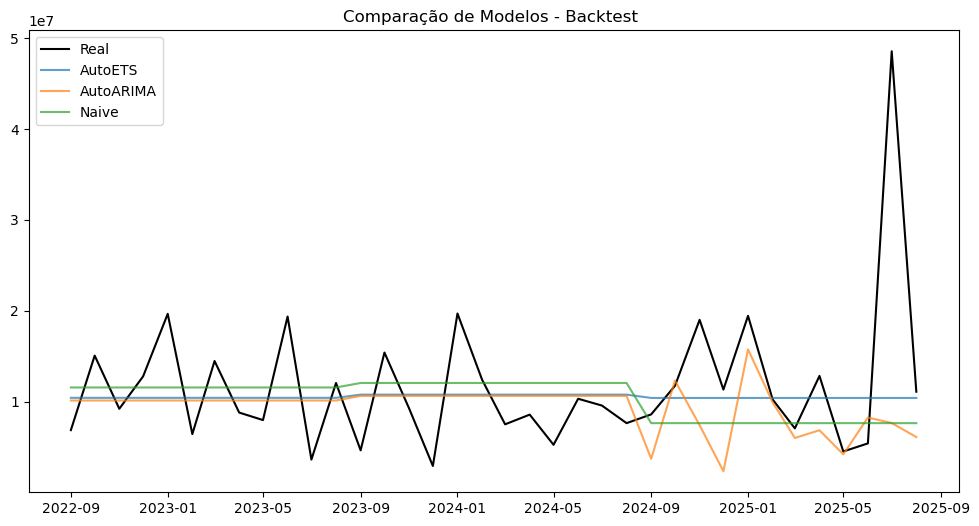

In [52]:
plt.figure(figsize=(12,6))
plt.plot(cv_results['ds'], cv_results['y'], label='Real', color='black')

for model in models_to_eval:
    plt.plot(cv_results['ds'], cv_results[model], label=model, alpha=0.7)

plt.legend()
plt.title("Comparação de Modelos - Backtest ")
plt.show()

In [53]:
# Melhor pelo RMSE (quanto menor, melhor)
best_rmse = metrics_df['RMSE'].idxmin()
print("📌 Melhor modelo pelo RMSE:", best_rmse)
print(metrics_df.loc[best_rmse], "\n")

# Melhor pelo MAE (quanto menor, melhor)
best_mae = metrics_df['MAE'].idxmin()
print("📌 Melhor modelo pelo MAE:", best_mae)
print(metrics_df.loc[best_mae], "\n")

# Melhor pelo MAPE (quanto menor, melhor)
best_mape = metrics_df['MAPE'].idxmin()
print("📌 Melhor modelo pelo MAPE:", best_mape)
print(metrics_df.loc[best_mape], "\n")

# Melhor pelo R² (quanto maior, melhor)
best_r2 = metrics_df['R2'].idxmax()
print("📌 Melhor modelo pelo R²:", best_r2)
print(metrics_df.loc[best_r2], "\n")



📌 Melhor modelo pelo RMSE: AutoETS
RMSE    7.913275e+06
MAE     4.843474e+06
MAPE    4.992860e+01
R2     -2.979469e-02
Name: AutoETS, dtype: float64 

📌 Melhor modelo pelo MAE: AutoETS
RMSE    7.913275e+06
MAE     4.843474e+06
MAPE    4.992860e+01
R2     -2.979469e-02
Name: AutoETS, dtype: float64 

📌 Melhor modelo pelo MAPE: XGBoost
RMSE    1.121372e+07
MAE     6.533703e+06
MAPE    4.163286e+01
R2      1.143754e-02
Name: XGBoost, dtype: float64 

📌 Melhor modelo pelo R²: RandomForest
RMSE    9.627055e+06
MAE     6.631916e+06
MAPE    4.984356e+01
R2      2.713954e-01
Name: RandomForest, dtype: float64 



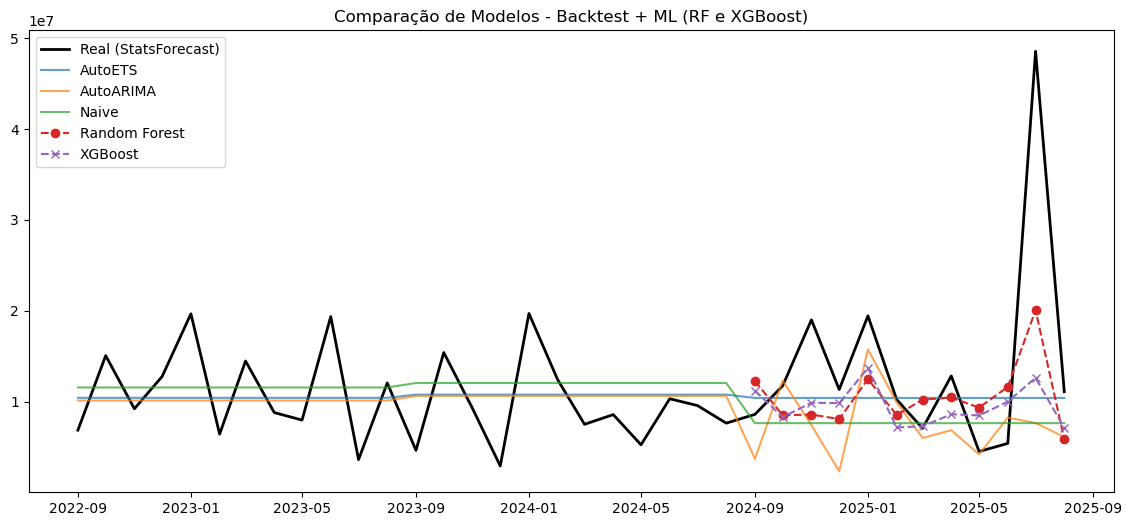

In [56]:

plt.figure(figsize=(14,6))

# Série real (StatsForecast backtest)
plt.plot(cv_results['ds'], cv_results['y'], label='Real (StatsForecast)', color='black', linewidth=2)

#Modelos do StatsForecast
for model in models_to_eval:
    plt.plot(cv_results['ds'], cv_results[model], label=model, alpha=0.7)

# Últimos 12 meses para ML
#plt.plot(df_ml['ds'][-12:], y_test, label="Real (ML - últimos 12 meses)", color="black", linestyle="--", linewidth=2)
plt.plot(df_ml['ds'][-12:], y_pred_rf, label="Random Forest", marker="o", linestyle="--")
plt.plot(df_ml['ds'][-12:], y_pred_xgb, label="XGBoost", marker="x", linestyle="--")

plt.legend()
plt.title("Comparação de Modelos - Backtest + ML (RF e XGBoost)")
plt.show()
